**Назаров Дмитрий Алексеевич 214-322**

# Задание 2 Сверточная нейронная сеть для классификации медицинских изображений

## Задание

Используя фреймворк Pytorch создать сверточную нейронную сеть LeNet, данную модель обучить и протестировать на базе MedMNIST.

Также необходимо подобрать гиперпараметры на обучающей и проверочной выборках и повысить точность работы модели для тестовой выборки. При улучшении или ухудшении точности в выводах описать гипотезу почему ваши изменения привели к такому результату.

## Источники

1. [Статья о LeNet](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf)
1. [Источник изображений и описание датасетов](https://medmnist.com/)
1. Training a Classifier [ENG](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)
1. Сверточная нейронная сеть на PyTorch [RUS](https://neurohive.io/ru/tutorial/cnn-na-pytorch/) / [ENG](https://adventuresinmachinelearning.com/convolutional-neural-networks-tutorial-in-pytorch/)
1. Понимание сверточных нейронных сетей через визуализации в PyTorch [RUS](https://habr.com/ru/post/436838/)

In [1]:
# С датасетами из MedMNIST идет модуль для python, который облегчает работу с ними. Ниже команда для установки и импорта этой библиотеки.

try:
    import medmnist
    print("module 'medmnist' is installed")
except ModuleNotFoundError:
    print("module 'medmnist' is not installed")
    # !pip install medmnist
    # import medmnist
    # print("Module 'medmnist' has been installed and imported")

from medmnist import INFO, Evaluator

c:\Users\Shrek\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


module 'medmnist' is installed


In [2]:
data_flag = 'organcmnist'  # выбираем один из датасетов

info = INFO[data_flag]

DataClass = getattr(medmnist, info['python_class'])

task = info['task']

In [3]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

In [4]:
BATCH_SIZE = 128

# предобработка данных
data_transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Загрузка данных и их разделение на выборки в датасете данные уже разделены на три подвыборки {'train': 13000, 'val': 2392, 'test': 8268}
train_dataset = DataClass(split='train', transform=data_transform, download=True)
val_dataset =  DataClass(split='val', transform=data_transform, download=True) # По аналогии с train_dataset создайте соответствующую подвыборку
test_dataset =  DataClass(split='test', transform=data_transform, download=True) # По аналогии с train_dataset создайте соответствующую подвыборку

# Передача данных в DataLoader из Pytorch
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader =  DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True) # По аналогии с train_loader создайте соответствующий загрузчик данных, но здесь для батча перемешивание не требуется
test_loader =  DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True) # По аналогии с train_loader создайте соответствующий загрузчик данных, но здесь для батча перемешивание не требуется

Using downloaded and verified file: C:\Users\Shrek\.medmnist\organcmnist.npz
Using downloaded and verified file: C:\Users\Shrek\.medmnist\organcmnist.npz
Using downloaded and verified file: C:\Users\Shrek\.medmnist\organcmnist.npz


## Краткая информация о датасете 

In [5]:
print(f"Задача: {task} классификация\nКоличество классов:{len(info['label'])}")
print("===================")
print(train_dataset)

Задача: multi-class классификация
Количество классов:11
Dataset OrganCMNIST (organcmnist)
    Number of datapoints: 13000
    Root location: C:\Users\Shrek\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 1
    Meaning of labels: {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'heart', '4': 'kidney-left', '5': 'kidney-right', '6': 'liver', '7': 'lung-left', '8': 'lung-right', '9': 'pancreas', '10': 'spleen'}
    Number of samples: {'train': 13000, 'val': 2392, 'test': 8268}
    Description: The OrganCMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Coronal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in coronal views (planes).

c:\Users\Shrek\AppData\Local\Programs\Python\Python310\lib\site-packages\medmnist\utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


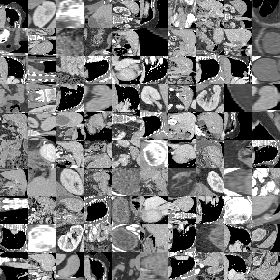

In [42]:
# Визуализация изображений

train_dataset.montage(length=10)

## Составляющие для обучения модели

Для решения задачи требуются:

1. Архитектура (нейронная сеть)
1. Цель (функция потерь / loss)
1. Оптимизатор (обновление параметров модели)

При работе с фреймворком PyTorch тогда потребуется:

1. Архитектура созданная с помощью API `nn.Module` или `nn.Sequential`.
2. Функция потерь из `nn.Module` или [` nn.functional`](https://pytorch.org/docs/stable/nn.functional.html) API.
3. Оптимизатор из [`torch.optim.Optimizer`](https://pytorch.org/docs/stable/optim.html).

Из [`nn.Module`](https://pytorch.org/docs/stable/nn.html) можно в готовом виде использовать, например:
- `nn.Linear`
- `nn.Conv1d`, `nn.Conv2d`
- `nn.MaxPool1d`, `nn.AdaptiveMaxPool1d`
- `nn.ReLU`, `nn.ELU`, `nn.LeakyReLU`, `nn.Tanh`, `nn.Sigmoid`
- `nn.BatchNorm1d`, `nn.BatchNorm2d`
- `nn.Dropout`
- Потери: `nn.CrossEntropyLoss`, `nn.NLLLoss`, `nn.MSELoss`

`nn.Sequential` позволяет создать последовательность различных модулей из ` nn.Module`. Они инициируются списком модулей, где выходные данные одного модуля идут в качестве входных данных для следующего.

## Реализуйте LeNet

На ваше усмотрение вы можете создать модель через новый класс отнаследовавшись от `nn.Module` или `nn.Sequential()` главное закомментировать и раскомментировать нужный код.

Архитектура:
* Свёртки 5x5, шаг 1, 1 карта на входе, 6 на выходе с активацией ReLU;
* MaxPooling 2x2, с шагом 2;
* Свёртки 5x5, шаг 1, 6 карт на входе, 16 на выходе с активацией ReLU;
* MaxPooling 2x2, с шагом 2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 11 нейронов.

In [12]:
# Или через nn.Sequential

model = nn.Sequential(
    nn.Conv2d(1,6,5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6,16,5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(400, 120),
    nn.Linear(120, 84),
    nn.Linear(84, 11)
)

# model = Net(in_channels=1, num_classes=11)

In [13]:
# Проверка есть ли в доступе GPU для обучения и использование модели на доступном устройстве

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Linear(in_features=120, out_features=84, bias=True)
  (9): Linear(in_features=84, out_features=11, bias=True)
)

In [46]:
# Описание построенной архитектуры

# from torchsummary import summary
# summary(model, (features,), batch_size=128)
# print(model)

In [14]:
NUM_EPOCHS = 10
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()

# Выберите один из вариантов оптимизатора 
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

## Обучение

Шаги для обучения на одном батче данных:
1. загрузить батч
2. выполнить прямой проход модели, получить выходы модели
3. рассчитать `loss`
4. выполнить `loss.backward ()` для вычисления градиентов функции потери относительно параметров модели
5. выполнить шаг оптимизации `optimizer.step ()`
6. занулить градиенты
7. провести валидацию после каждой эпохи

Общий подход к обучению НС с использованием PyTorch


```python
for epoch in range(max_epochs):
    model.train()
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outp = model(inputs)
        loss = criterion(outp, targets)
        loss.backward()
        optimizer.step()
```

In [15]:
# train
history = []

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    model.train()
    for inputs, targets in tqdm(train_loader):
        
        # ***Начало вашего кода***
        optimizer.zero_grad()
        outp=model(inputs)
        loss=criterion(outp, targets.squeeze().long())
        loss.backward()
        optimizer.step()
        # Для расчета loss с использованием созданного критерия, потребуется изменить размерность меток - targets.squeeze().long()
        # pass
        # ***Конец вашего кода***
        
        history.append(loss.item())

100%|██████████| 102/102 [00:04<00:00, 20.89it/s]


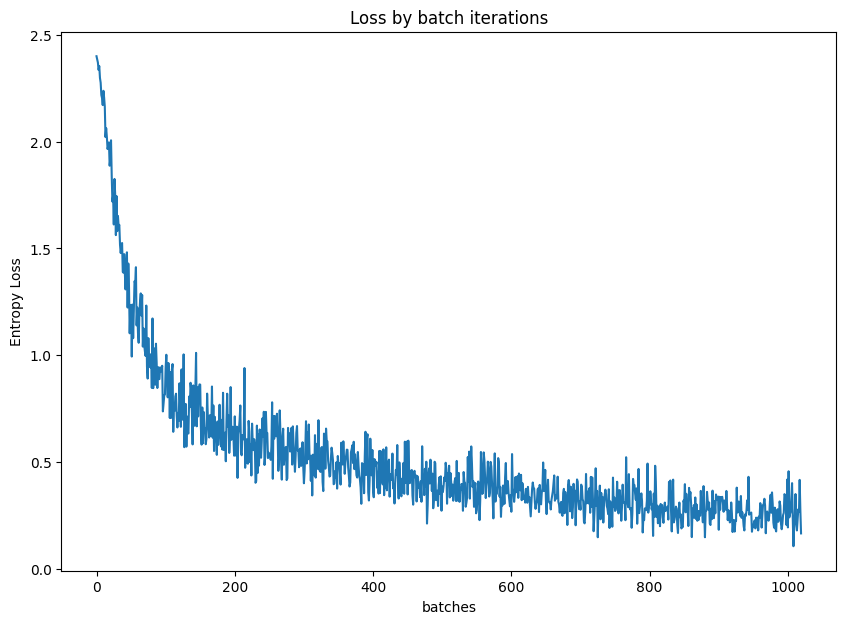

In [16]:
# График для потерь по мере обучения

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(history)
plt.title('Loss by batch iterations')
plt.ylabel('Entropy Loss')
plt.xlabel('batches')
plt.show()

In [19]:
# Функция для оценки работы модели

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

In [20]:
test('test')

test  auc: 0.500  acc:0.112


## Подбор гиперпараметров

Попробовать модифицировать гиперпараметры и архитектуру сети для повышения точности ее работы.

In [27]:
NUM_EPOCHS = 100
learning_rate = 0.001

model = nn.Sequential(
    nn.Conv2d(1,6,5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6,16,5),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Flatten(),
    nn.Linear(400, 120),
    nn.Linear(120, 84),
    nn.Linear(84, 11)
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Sequential(
  (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): Linear(in_features=120, out_features=84, bias=True)
  (9): Linear(in_features=84, out_features=11, bias=True)
)

In [28]:
# train
history = []

optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate)

for epoch in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    model.train()
    for inputs, targets in tqdm(train_loader):
        
        # ***Начало вашего кода***
        optimizer.zero_grad()
        outp=model(inputs)
        loss=criterion(outp, targets.squeeze().long())
        loss.backward()
        optimizer.step()
        # Для расчета loss с использованием созданного критерия, потребуется изменить размерность меток - targets.squeeze().long()
        # pass
        # ***Конец вашего кода***
        
        history.append(loss.item())

100%|██████████| 102/102 [00:07<00:00, 12.89it/s]


In [37]:
# Функция для оценки работы модели

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            targets = targets.squeeze().long()
            outputs = outputs.softmax(dim=-1)
            targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))
        return metrics

test_acc=test('test')[1]

test  auc: 0.496  acc:0.112


## Результат на тестовой выборке для лучшей модели

In [38]:
print('Точность на тестовой выборке: ', test_acc)

Точность на тестовой выборке:  0.11163522012578617


## Анализ данных

Проанализировать данные и сделать выводы о возможных проблемах.

_Ваш ответ здесь_

1) Алгоритм имеет низкую точность точность определения результатов.
2) Увеличение кол-ва эпох не влияет на повышение точности результатов.
3) Низкая точность результатов может быть вызвана неграмотно сформированным алгоритмом обучения или общей архитектурой программного кода.